# Brain_tumor_ai_detection Prject


# 🏷️ Imports and Environment Setup


In [19]:
import os
import zipfile
import random
import shutil
import torch
import torchvision
import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import math

from torchvision import transforms, datasets, models
from torch import nn
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#  Unzip Dataset

In [4]:
zip_path = "archive (1).zip"
data_path = "/content/BrainTumorData"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 🖼️ Load Dataset and Split into Train/Test

In [7]:
dataset = datasets.ImageFolder(os.path.join(data_path, "brain_tumor_dataset"), transform=transform)
class_to_idx = dataset.class_to_idx

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

C:\Users\asus\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training Loop

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    model.eval()
    test_preds, test_labels_out = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_labels_out.extend(labels.numpy())

    acc = accuracy_score(test_labels_out, test_preds)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} - Test Acc: {acc:.4f}")


Epoch [1/10] - Loss: 0.4978 - Test Acc: 0.8824
Epoch [2/10] - Loss: 0.0832 - Test Acc: 0.9216
Epoch [3/10] - Loss: 0.0264 - Test Acc: 0.9020
Epoch [4/10] - Loss: 0.0138 - Test Acc: 0.8824
Epoch [5/10] - Loss: 0.0097 - Test Acc: 0.8824
Epoch [6/10] - Loss: 0.0051 - Test Acc: 0.9020
Epoch [7/10] - Loss: 0.0067 - Test Acc: 0.9020
Epoch [8/10] - Loss: 0.0028 - Test Acc: 0.9020
Epoch [9/10] - Loss: 0.0013 - Test Acc: 0.9216
Epoch [10/10] - Loss: 0.0021 - Test Acc: 0.9216


# Final Evaluation on Test Set

In [12]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f" Accuracy: {test_acc:.2f}%")

 Accuracy: 92.16%


# Classification Report

In [27]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=list(idx_to_class.values())))


Classification Report:

              precision    recall  f1-score   support

          no       0.88      0.88      0.88        16
         yes       0.94      0.94      0.94        35

    accuracy                           0.92        51
   macro avg       0.91      0.91      0.91        51
weighted avg       0.92      0.92      0.92        51



#  Confusion Matrix Visualization

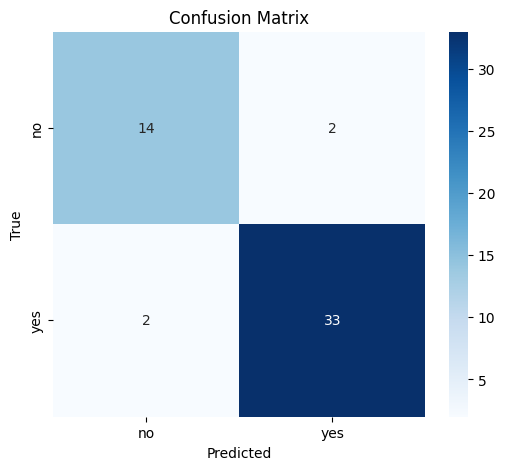

In [29]:
cm = confusion_matrix(all_labels, all_preds)

idx_to_class = {v: k for k, v in class_to_idx.items()}
labels = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#  Display Sample Test Images with Predictions

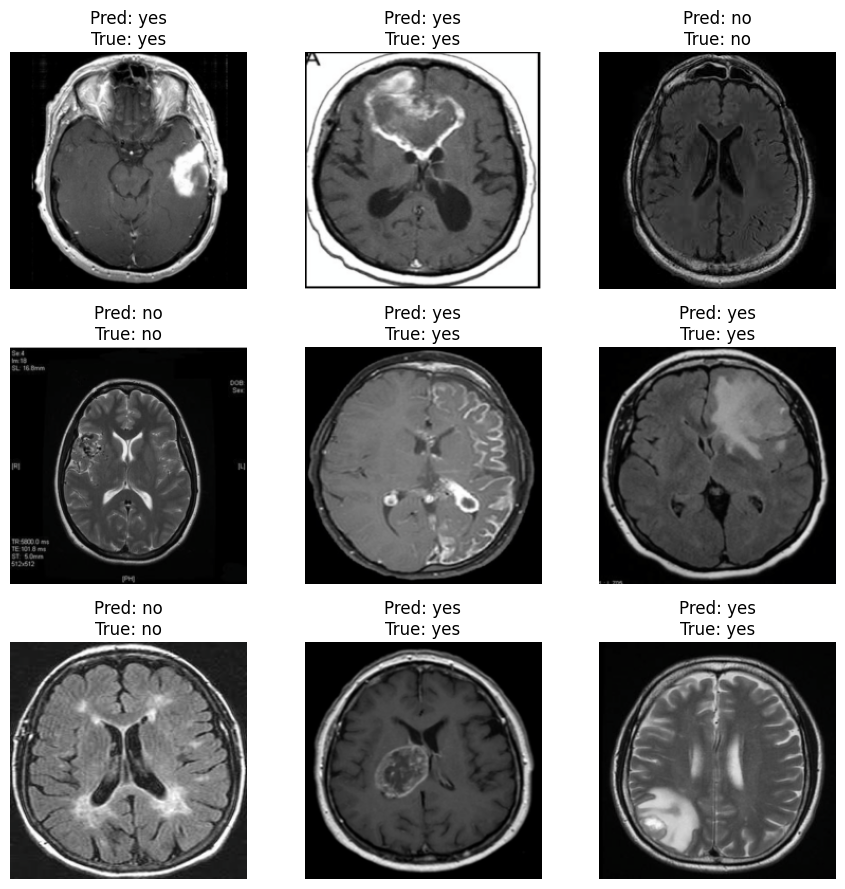

In [31]:
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  
axes = axes.flatten()

with torch.no_grad():
    for i in range(9):
        img, label = test_dataset[i]
        img_input = img.unsqueeze(0).to(device)  
        output = model(img_input)
        pred = torch.argmax(output, dim=1).item()

        img_show = img.permute(1, 2, 0).cpu().numpy()
        img_show = np.clip(img_show * np.array([0.229, 0.224, 0.225]) + 
                           np.array([0.485, 0.456, 0.406]), 0, 1)

        axes[i].imshow(img_show)
        axes[i].set_title(f"Pred: {idx_to_class[pred]}\nTrue: {idx_to_class[label]}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Load and Display External Test Images with Predictions

In [33]:
zip_path = "test.zip"
test_images_folder = "/content/testBrainTumorData"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_images_folder)
for img_path in glob.glob(f"{test_images_folder}/*.jpg"):
    pred = predict_image(img_path, model, transform, idx_to_class)
    print(f"{os.path.basename(img_path)} → {pred}")

In [51]:
def predict_image(image_path, model, transform, idx_to_class):
    model.eval()  
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)  
    with torch.no_grad():
        output = model(img_t)
        pred = torch.argmax(output, dim=1).item()
    return idx_to_class[pred]

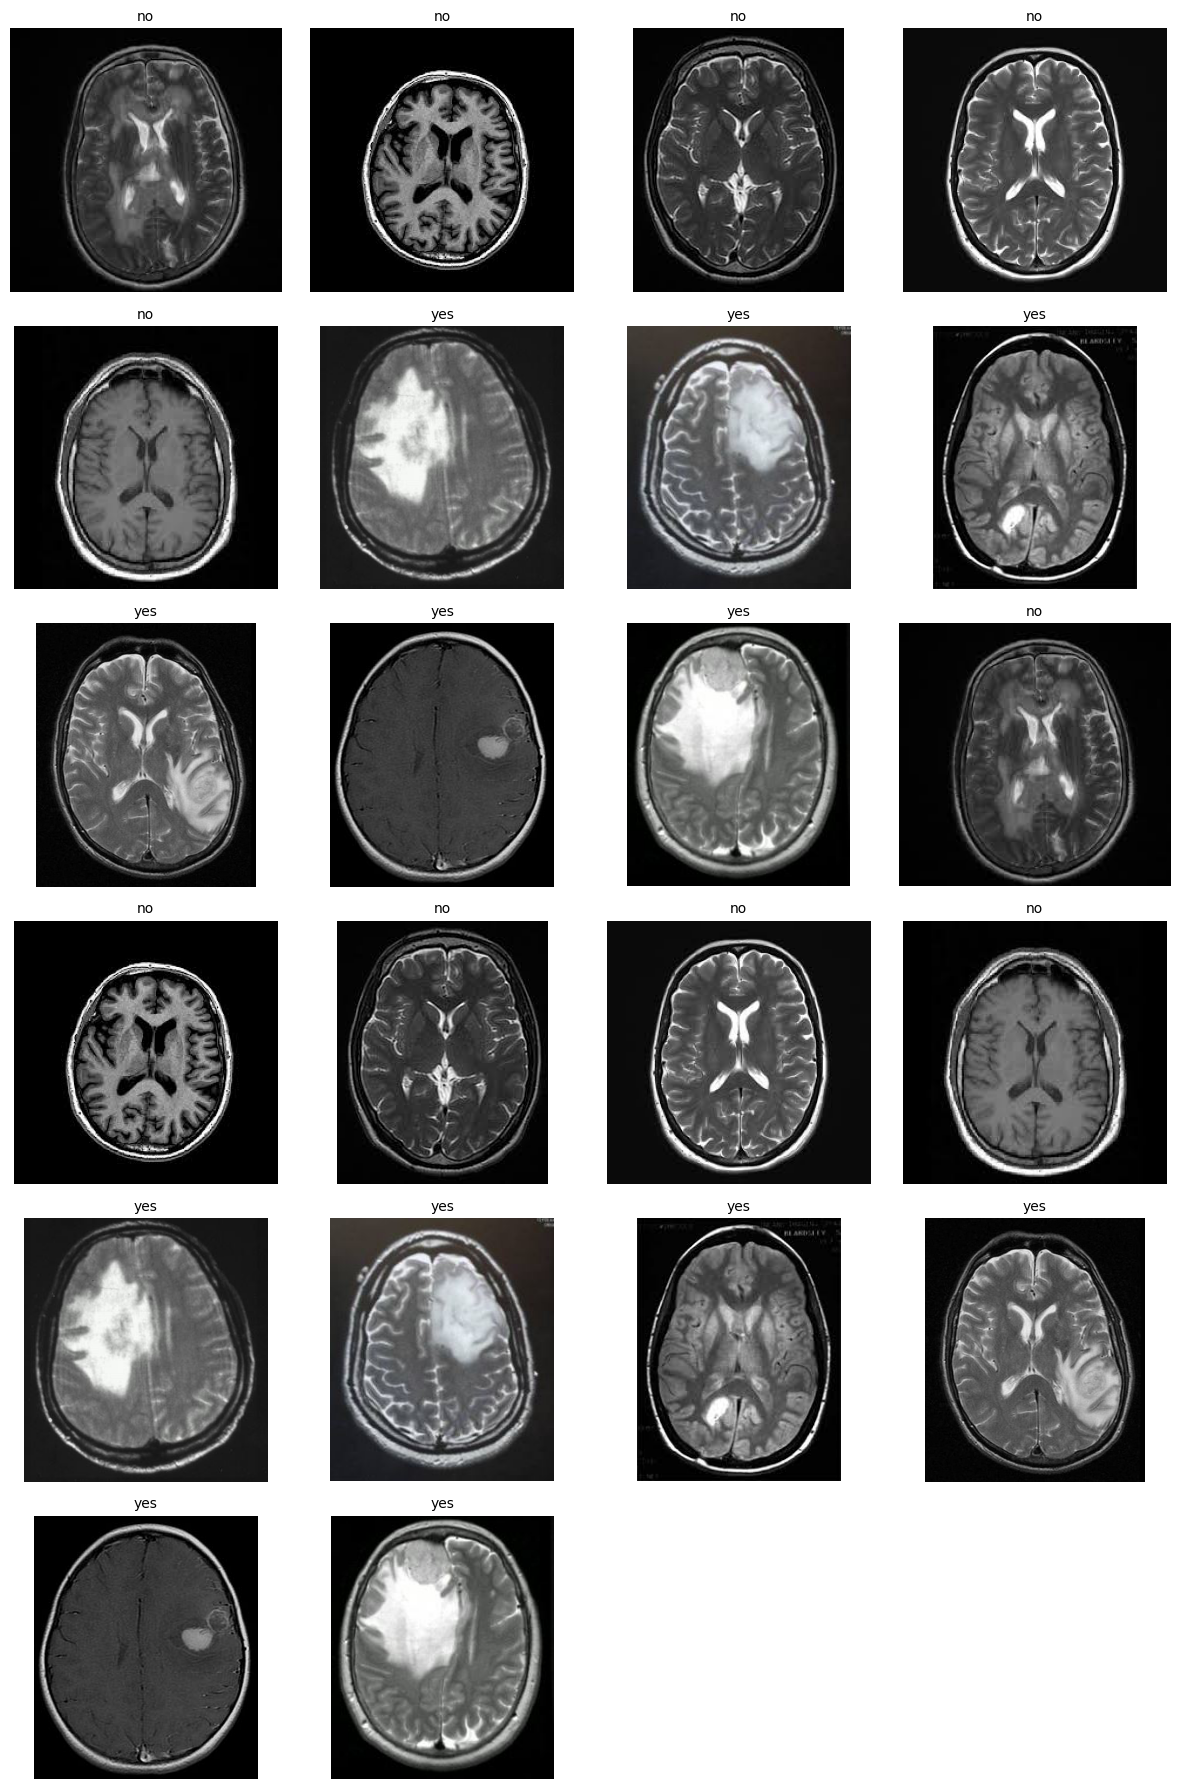

In [68]:
images_per_row = 4
num_images = len(all_image_paths)
num_rows = math.ceil(num_images / images_per_row)

plt.figure(figsize=(images_per_row * 3, num_rows * 3))  

for i, img_path in enumerate(all_image_paths):
    img = safe_open_image(img_path)
    if img is None:
        continue

    pred = predict_image(img_path, model, transform, idx_to_class)

    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(img)
    plt.title(pred, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()